#Monthly BZCAT comparison 
Read in the "bzcat_summary" files generated by the association analysis for each month, and for the 6-year model. Those files, indexed by the name, have the association info, the name of the 6-year source, and TS of the fit. 

In [1]:
%matplotlib inline
os.chdir(os.path.expandvars('$FERMI/skymodels/P301_monthly'))
import glob, pickle
ff = sorted(glob.glob('month*/plots/associations/bzcat_summary*.csv')); print 'found %d months' %len(ff)

found 12 months


Compile all the monthly files, make a list of the unique names.

In [2]:
monthlist = [int(f[5:7]) for f in ff]; 
bzm = [pd.read_csv(f, index_col=0) for f in ff]
bznames=[] 
for bz in bzm:
    bznames.append(list(bz.index))
sets = map(set, bznames)
# make a combined table of bzcat associations
a = sets[0]
for b in sets[1:]:
    a = a.union(b)
bznames = sorted(a); 
print 'Found %d unique names in %d months' % (len(bznames),len(monthlist)) 
np.asarray(bzm[0].columns, str)

Found 126 unique names in 12 months


array(['ang', 'dec', 'deltats', 'locqual', 'ra', 'sname', 'ts', 'type'], 
      dtype='|S7')

Get the list of associations from the 6-year run.

Compare it with the set of names from the monthly analyses

Idealy, there should be no overlap, since the 6-year sources are input to the source finding procedure. Two things can happen:
1. The 6-year source was discarded by mistake
2. The new source is close enough to get associated. 

In [3]:
bz6 = pd.read_csv(os.path.expandvars('$FERMI/skymodels/P301_6years/uw972/plots/associations/bzcat_summary.csv'),index_col=0)
bz6names=set(bz6.index)
insix =set(bznames).intersection(bz6names)
print '%d monthly names are in the 6-year list of %d names' % (len(insix), len(bznames))

71 monthly names are in the 6-year list of 126 names


Make a DataFrame with the bzname index, and monthly info

In [4]:
from skymaps import SkyDir, Band
bb = dict()
for bzname in bznames:
    tss = [0]*len(bzm)
    for i,tlist in enumerate(bzm):
        if bzname not in tlist.index: continue
        j = list(tlist.index).index(bzname)
        tss[i] = round(tlist.ts[j],1)
    bb[bzname] = dict(ts=tss,)
df = pd.DataFrame(bb).T
df.index.name='bzcat_name'
df['tsmax'] = [max(ts) for ts in df.ts]
df['months']= [sum(np.array(ts)>0) for ts in df.ts]
df['type'] = [name[3] for name in df.index]
df['ts6'] = bz6.ts.round(1)
df['y6name'] = bz6.sname
df['ra']  = bz6.ra
df['dec'] = bz6.dec
df['roi'] = [-1 if np.isnan(ra) else Band(12).index(SkyDir(ra,dec)) for ra,dec in zip(df.ra,df.dec)]
df['notin6y'] = [not isinstance(x, str) for x in df.y6name]; 
df.ix[0]

ts         [0, 0, 0, 0, 0, 12.0, 0, 0, 0, 0, 0, 0]
tsmax                                           12
months                                           1
type                                             B
ts6                                          324.8
y6name                                    P86Y0091
ra                                         5.50033
dec                                      -51.67339
roi                                           1640
notin6y                                      False
Name: 5BZBJ0022-5140, dtype: object

Examine the list of new associations

In [6]:
df.ix[df.notin6y & (df.tsmax>10)]['ts tsmax months type'.split()]

,ts,tsmax,months,type
bzcat_name,,,,
5BZBJ0122+1510,"[0, 0, 0, 0, 0, 0, 0, 0, 15.7, 0, 0, 0]",15.7,1,B
5BZBJ0621+1747,"[0, 0, 0, 13.2, 0, 0, 0, 0, 0, 0, 0, 0]",13.2,1,B
5BZBJ0803+2437,"[0, 0, 22.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]",22.5,1,B
5BZBJ0859+8345,"[11.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",11.2,1,B
5BZBJ1057-0059,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 13.7, 0, 0]",13.7,1,B
5BZBJ1744-0518,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 12.8, 0, 0]",12.8,1,B
5BZBJ1759+7037,"[10.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10.4,1,B
5BZBJ2136-4443,"[0, 17.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",17.0,1,B
5BZGJ0012-1628,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 14.8, 0, 0]",14.8,1,G


In [8]:
nm =[sum( [ts[m]>0 for ts in df.ts]) for m in range(len(monthlist))]; 
ngood=[sum( [((ts[m]>0) & b) for ts,b in zip(df.ts,df.notin6y)]) for m in range(len(monthlist))]; 
nm,ngood

([14, 15, 10, 8, 6, 13, 16, 14, 12, 16, 11, 23],
 [7, 8, 3, 4, 1, 3, 3, 5, 6, 6, 4, 6])

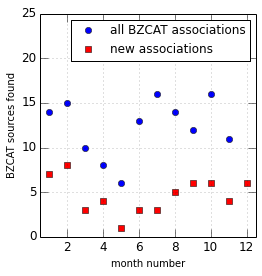

In [9]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(monthlist,[len(bz) for bz in bzm],  'o', label='all BZCAT associations')
ax.plot(monthlist, ngood, 'sr', label='new associations')
plt.setp(ax, xlim=(0.5, monthlist[-1]+0.5), xlabel='month number', ylim=(0,None),ylabel='BZCAT sources found')
ax.grid(True, alpha=0.5)
ax.legend()

In [10]:
types = set(list(df.type))
tc = [sum(df.type==type) for type in types]
pd.DataFrame(dict(zip(types, tc)), index=['number']).T

,number
B,41
G,7
Q,68
U,10


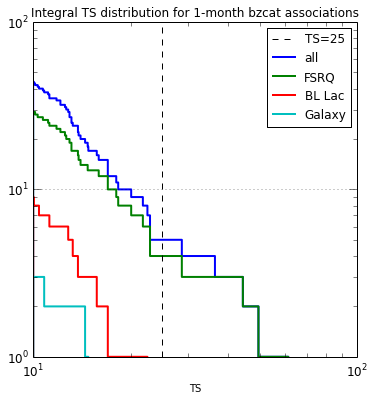

In [11]:
# make an integral logTS plot for the new 1-month guys
dfnew = df[df.notin6y]
fig, ax = plt.subplots(figsize=(6,6))
tsmax=100
dom = np.logspace(1,np.log10(tsmax),500)
hist_kw = dict( cumulative=-1, lw=2, histtype='step', log=True)
ax.axvline(25, color='k', ls='--', label='TS=25')

ax.hist(dfnew.tsmax[dfnew.months==1], dom, label='all', **hist_kw );

for type,label in zip('QBG', ['FSRQ', 'BL Lac', 'Galaxy']):
    sel = (dfnew.months==1)& (dfnew.type==type)
    if sum(sel)>0:
        try:
            ax.hist(dfnew.tsmax[sel], dom, label=label, **hist_kw)
        except: pass

plt.setp(ax, xscale='log', xlabel='TS', ylim=(1,None), xlim=(10, tsmax),
        title='Integral TS distribution for 1-month bzcat associations')
ax.grid(True, alpha=0.8);

leg=ax.legend()
for pbox in leg.get_patches():
    pbox._height=0; pbox._y=5